In [18]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Algorithm Implementations

### PCA Implementation

In [10]:
import numpy as np

class MyPCA:
    def __init__(self, num_components=2):
        self.num_components = num_components

    def fit(self, X): # X is of shape (num_samples, num_features)
        #Subtract Means
        X_mean = np.mean(X, axis=0).reshape(1, -1)
        X_norm = (X - X_mean)

        #Calculate Covariance
        covariance = np.matmul(X_norm.transpose(), X_norm) / X_norm.shape[0]

        #Calculate Eigenvectors & Eigenvalues
        eigenvalues, eigenvectors = np.linalg.eig(covariance)

        #Sort Eigenvectros according to Eigenvalues
        idx = eigenvalues.argsort()[::-1]     
        sorted_vecs = (eigenvectors[:, idx])   
        eigenvalues = eigenvalues[idx]
        self.prinicple_components_ = sorted_vecs[:,:self.num_components] 
                
    def project(self, X):
        X_mean = np.mean(X, axis=0).reshape(1, -1)
        X_norm = (X - X_mean)
        return np.matmul(X_norm, self.prinicple_components_)

### K-Means Implementation

In [21]:
class MyKmeans:
    def __init__(self, num_centroids = 2, max_iters = 100, max_trials = 10):
        self.num_centroids = num_centroids
        self.max_iters = max_iters
        self.max_trials = max_trials

    def calculate_error(self, X, centroids, labels): #X: (num_samples, num_features), Labels: (num_samples), Centroids: (num_centroids, num_features)
        error = 0
        for i in range(self.num_centroids):
            cluster_points = X[labels==i]
            error += np.square(cluster_points - centroids[i]).sum() #Cluster Error
        return error


    def train_multiple_trials(self, X):
        min_error = float('inf')
        min_centroids = None
        min_labels = None

        for _ in range(self.max_trials):
            centroids, labels = self.train_fast(X)
            error = self.calculate_error(X, centroids, labels)
            if error < min_error:
                min_error = error
                min_centroids = centroids
                min_labels = labels

        return min_centroids, min_labels


    #Slower but simpler implementation
    def train(self, X): # X is of shape (num_samples, num_features)
        centroids = X[np.random.choice(range(X.shape[0]), self.num_centroids, replace=False)]
        for _ in range(self.max_iters):
            #Measure Distances to Centroids
            distances = np.zeros((X.shape[0], self.num_centroids)) #Shape: (num_samples, num_centroids)            
            for i in range(X.shape[0]):
                for j in range(self.num_centroids):
                    distances[i][j] = np.linalg.norm(X[i]-centroids[j])            

            #Assign Points to Clusters
            labels = np.argmin(distances, axis=1)

            new_centroids = np.zeros((self.num_centroids, X.shape[1]))
            #Recalculate Centroids
            for i in range(self.num_centroids):
                cluster_points = X[labels==i]
                new_centroids[i] = cluster_points.mean(axis=0)
            
            # Check convergence
            if np.all(centroids == new_centroids):
                break
            
            centroids = new_centroids
        
        return centroids, labels


    def train_fast(self, X): # X is of shape (num_samples, num_features)
        # Initialize centroids randomly
        centroids = X[np.random.choice(range(X.shape[0]), self.num_centroids, replace=False)]
        
        for _ in range(self.max_iters):
            # Assign each data point to the nearest centroid
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            
            # Update centroids
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.num_centroids)])
            
            # Check convergence
            if np.all(centroids == new_centroids):
                break
            
            centroids = new_centroids
        
        return centroids, labels

## Data Preparation

In [7]:
data =  pd.read_csv("data.csv")

data = data.drop(columns=['id', 'Unnamed: 32']) #Remove Unnecessary Columns
X = data.drop(columns=["diagnosis"])
y = data[["diagnosis"]]

In [13]:
#Normalizing Data
X_normalized = (X - X.mean()) / X.std()
X_normalized_arr = X_normalized.to_numpy()

## Experiment 1: K-Means Only

### Finding Best Number of Clusters Using Elbow Method

K found using elbow method = 15

In [42]:
k = [i+1 for i in range(30)]
errors = []

for i in k:
    k_means = MyKmeans(num_centroids=i, max_iters=100, max_trials=10)
    centroids, labels = k_means.train_multiple_trials(X_normalized_arr)
    errors.append(k_means.calculate_error(X_normalized_arr, centroids, labels))


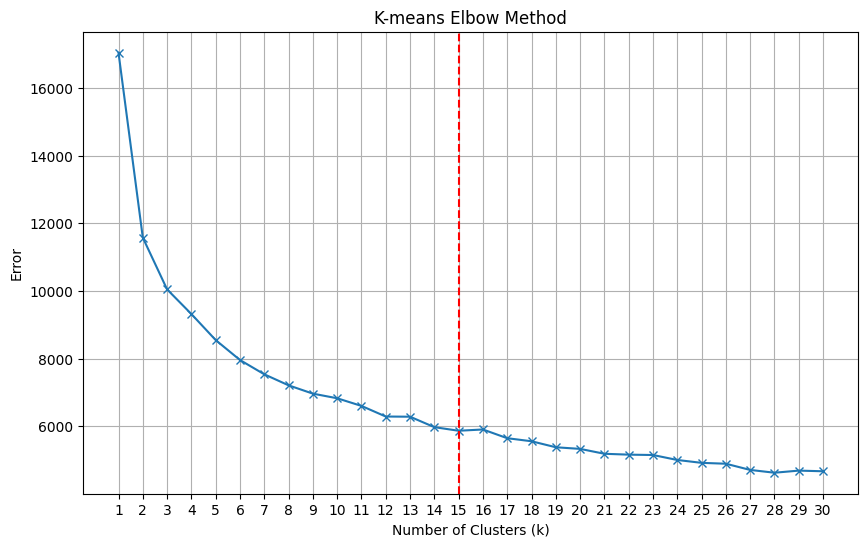

In [46]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(k, errors, marker='x', linestyle='-')  # 'x' markers for data points, solid line
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Error')
plt.title('K-means Elbow Method')
plt.xticks(k)
plt.grid(True)
plt.axvline(x=15, color='red', linestyle='--')
plt.show()

In [49]:
#Total Error for K = 15

error_exp1 = errors[14]
print(error_exp1)

5865.526030335315


## Experiment 2: K-Means & PCA